In [1]:
import PQ
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
# 使用CPU训练
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

加载Cifar数据集

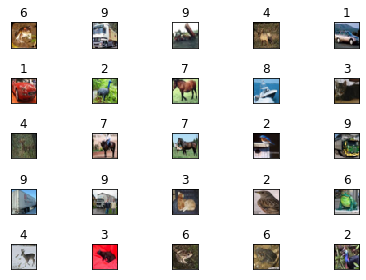

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_x = []
train_y = []
# 读取训练数据集
for i in range(5):
    file = "./dataSet/data_batch_%d"%(i+1)
    dicts = unpickle(file)
    labels = dicts[b'labels']
    data = dicts[b'data'].reshape(-1, 3, 32, 32) # 3*32x32
    data = data.transpose(0,2,3,1)

    for j in range(len(labels)):
        img_data = data[j]
        label = labels[j]
        train_x.append(img_data)
        train_y.append(label)
# 读取测试数据集
test_x = []
test_y = []
for i in range(1):
    # file = "./data_batch_%d"%(i+1)
    file = "./dataSet/test_batch"
    dicts = unpickle(file)
    labels = dicts[b'labels']
    data = dicts[b'data'].reshape(-1, 3, 32, 32) # 3*32x32
    data = data.transpose(0,2,3,1)

    for j in range(len(labels)):
        img_data = data[j]
        label = labels[j]
        test_x.append(img_data)
        test_y.append(label)
# 画图函数
def matplotMnist(x_train, y_train):
    fig, ax = plt.subplots(nrows=5, ncols=5, sharex='all', sharey='all')
    ax = ax.flatten()
    for i in range(25):
        img = x_train[i].reshape(32, 32, 3)
        ax[i].set_title(y_train[i])
        ax[i].imshow(img)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
matplotMnist(train_x, train_y)

In [4]:
train_x = np.array(train_x)
train_x = train_x.flatten()
train_x = train_x.reshape((-1, 3072))
print(train_x.shape)

(50000, 3072)


In [5]:
train_y = np.array(train_y)
print(train_y)

[6 9 9 ... 9 1 1]


数据集处理结束

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_train_x = pca.fit_transform(train_x)

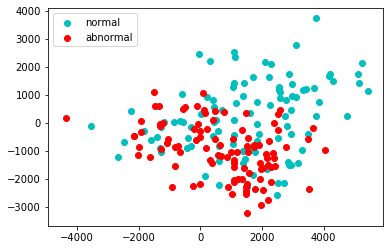

In [7]:
plt.scatter(pca_train_x[train_y == 0,0][:100],pca_train_x[train_y == 0,1][:100],color='c', label="normal")
plt.scatter(pca_train_x[train_y == 9,0][:100],pca_train_x[train_y == 9,1][:100],color='r',label="abnormal")
plt.legend()
plt.show()

In [11]:
# 拿出我们的 PQ Table C
f = open('./dataSet/C_3.txt', 'rb')
C_1 = pickle.load(f)

# 用模型进行推理
model = tf.saved_model.load("./view_model/LPQ")
infer = model.signatures['serving_default']
test_x = train_x[train_y == 0][:100]
test_x = np.vstack((test_x, train_x[train_y == 9][:100]))
test_x = tf.cast(test_x, tf.float32)
predict_x = infer(test_x)

In [12]:
result = predict_x['output_0'].numpy()

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result)
pca_C_1 = pca.transform(C_1[0])

In [14]:
pca_C_1[0][0]

-373.15982

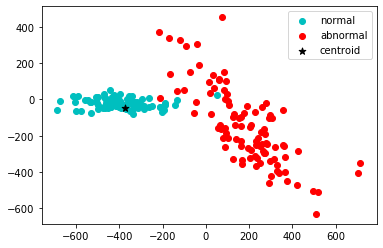

In [15]:
plt.scatter(pca_result[:100][:, 0],pca_result[:100][:, 1],color='c', label="normal")
plt.scatter(result[100:][:, 0],result[100:][:, 1],color='r',label="abnormal")
plt.scatter(pca_C_1[0][0],pca_C_1[0][1], marker='*', s=50, color='black', label="centroid")
plt.legend()
plt.show()